Import Libraries

5/21, 5/22, 5/24 seems to have decent data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as signal
import math
sns.set_palette('muted')
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore") # 

# 5/21/19 Muse EEG data. 
-- The mobile EEG has four channels TP9, AF7, AF8, TP10 based on locations from an international 10-20 EEG system. Importing the data.

In [2]:
data_5_21 = pd.read_csv('/Users/isaacmenchaca/Desktop/reanalysis/sleepData1.csv')
data_5_21['TimeStamp'] = pd.to_datetime(data_5_21['TimeStamp'])
data_5_21 = data_5_21.set_index('TimeStamp')
display(data_5_21[['RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10']])

,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10
TimeStamp,,,,
2019-05-21 00:51:36.539,796.593407,873.150183,866.703297,834.065934
2019-05-21 00:51:37.548,853.406593,884.029304,882.417582,840.512821
2019-05-21 00:51:38.539,843.736264,882.820513,873.956044,834.468864
2019-05-21 00:51:39.584,808.278388,881.208791,880.402930,820.769231
2019-05-21 00:51:40.611,839.304029,873.150183,868.315018,736.153846
...,...,...,...,...
2019-05-21 02:33:43.616,888.461538,839.304029,875.567766,856.630037
2019-05-21 02:33:44.568,884.432234,1013.369963,1342.564103,801.025641
2019-05-21 02:33:45.520,846.153846,1085.494505,1100.805861,827.619048


# Interpolate NaN values from mobile EEG channels for analysis
-- the device obtains NaN values for all of the channels when it detects a blink or jaw clench. Will lead to all four channels obtaining Nans at the same time.

-- I do not intend to clean outliers/ dropped signal since those cannot be accounted for in real-time. The NaNs are an exception because they are caused by artifact detection from the EEG.

In [3]:
def NaNsFromChannel(df, data):
    nans = [df.index[i] for i, value in enumerate(data) if np.isnan(value)]
    return nans

RAW_AF7_nans = NaNsFromChannel(data_5_21, data_5_21.RAW_AF7)
RAW_AF8_nans = NaNsFromChannel(data_5_21, data_5_21.RAW_AF8)
RAW_TP9_nans = NaNsFromChannel(data_5_21, data_5_21.RAW_TP9)
RAW_TP10_nans = NaNsFromChannel(data_5_21, data_5_21.RAW_TP10)

-- plot the time series and where the NaNs are.

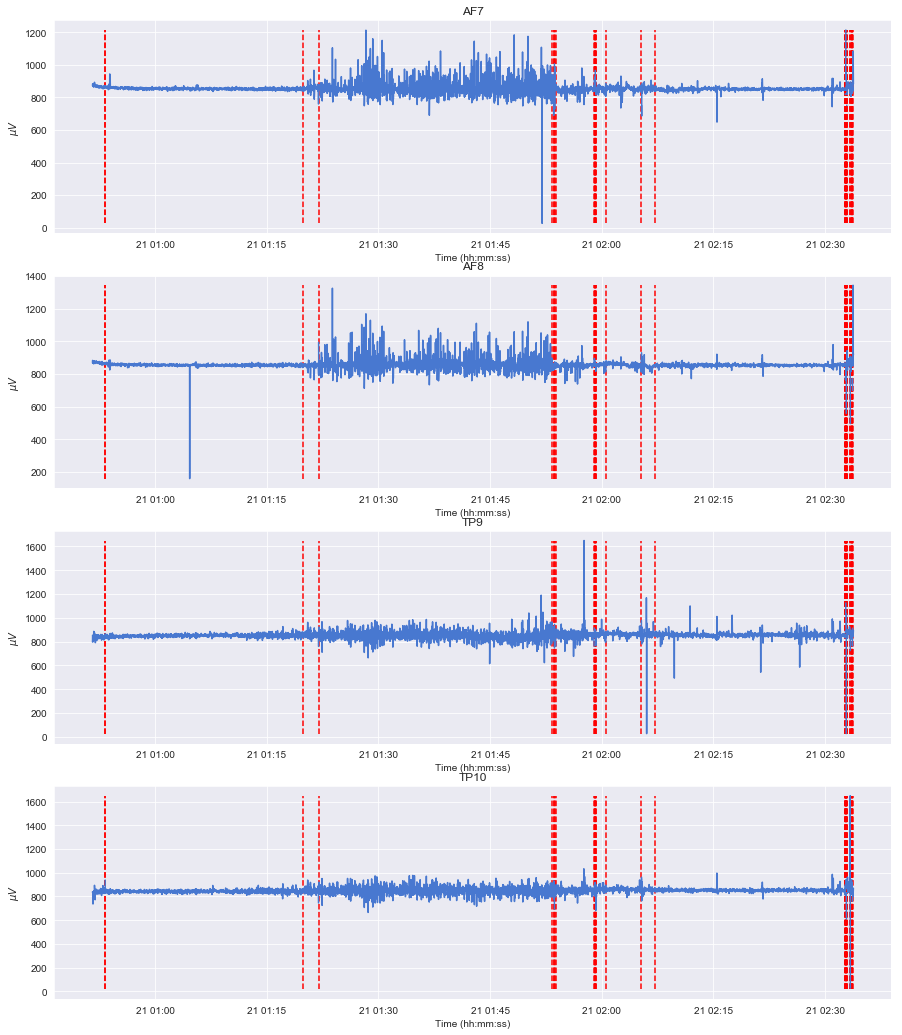

In [4]:

plt.figure(figsize= (15, 18))

plt.subplot(4, 1, 1)
plt.plot(data_5_21.index, data_5_21.RAW_AF7)
ymin = np.amin(data_5_21.RAW_AF7)
ymax = np.amax(data_5_21.RAW_AF7)
plt.title('AF7')
plt.ylabel(r'$ \mu V $')
plt.xlabel('Time (hh:mm:ss)')
for nan in RAW_AF7_nans:
    plt.vlines(x = nan,ymin = ymin, ymax = ymax, linestyles='dashed', 
           colors='r')
    
plt.subplot(4, 1, 2)
plt.plot(data_5_21.index, data_5_21.RAW_AF8)
ymin = np.amin(data_5_21.RAW_AF8)
ymax = np.amax(data_5_21.RAW_AF8)
plt.title('AF8')
plt.ylabel(r'$ \mu V $')
plt.xlabel('Time (hh:mm:ss)')
for nan in RAW_AF8_nans:
    plt.vlines(x = nan,ymin = ymin, ymax = ymax, linestyles='dashed', 
           colors='r')

plt.subplot(4, 1, 3)
plt.plot(data_5_21.index, data_5_21.RAW_TP9)
ymin = np.amin(data_5_21.RAW_TP9)
ymax = np.amax(data_5_21.RAW_TP9)
plt.title('TP9')
plt.ylabel(r'$ \mu V $')
plt.xlabel('Time (hh:mm:ss)')
for nan in RAW_TP9_nans:
    plt.vlines(x = nan,ymin = ymin, ymax = ymax, linestyles='dashed', 
           colors='r')

plt.subplot(4, 1, 4)
plt.plot(data_5_21.index, data_5_21.RAW_TP10)
ymin = np.amin(data_5_21.RAW_TP10)
ymax = np.amax(data_5_21.RAW_TP10)
plt.title('TP10')
plt.ylabel(r'$ \mu V $')
plt.xlabel('Time (hh:mm:ss)')
for nan in RAW_TP10_nans:
    plt.vlines(x = nan,ymin = ymin, ymax = ymax, linestyles='dashed', 
           colors='r')
plt.show()

### Quick clean via interpolation on NaN

-- Interpolate over NaNs

In [5]:
def interpolateNaNs(channelData):
    nans =  np.isnan(channelData)
    x = lambda z: z.to_numpy().nonzero()[0]
    
    interpolated = channelData.copy()
    interpolated[nans] = np.interp(x(nans), x(~nans), channelData[~nans])
    return interpolated

data_5_21['clean_RAW_AF7'] = interpolateNaNs(data_5_21.RAW_AF7)
data_5_21['clean_RAW_AF8'] = interpolateNaNs(data_5_21.RAW_AF8)
data_5_21['clean_RAW_TP9'] = interpolateNaNs(data_5_21.RAW_TP9)
data_5_21['clean_RAW_TP10'] = interpolateNaNs(data_5_21.RAW_TP10)

-- plot the interpolated time series and check for any NaNs. None are found.

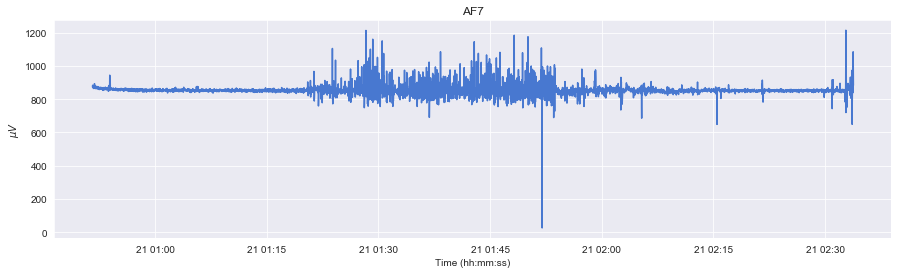

In [6]:
clean_RAW_AF7_nans = NaNsFromChannel(data_5_21, data_5_21.clean_RAW_AF7)
clean_RAW_AF8_nans = NaNsFromChannel(data_5_21, data_5_21.clean_RAW_AF8)
clean_RAW_TP9_nans = NaNsFromChannel(data_5_21, data_5_21.clean_RAW_TP9)
clean_RAW_TP10_nans = NaNsFromChannel(data_5_21, data_5_21.clean_RAW_TP10)



plt.figure(figsize= (15, 4))

plt.plot(data_5_21.clean_RAW_AF7)
ymin = np.amin(data_5_21.clean_RAW_AF7)
ymax = np.amax(data_5_21.clean_RAW_AF7)
plt.title('AF7')
plt.xlabel('Time (hh:mm:ss)')
plt.ylabel(r'$ \mu V $')
for nan in clean_RAW_AF7_nans:
    plt.vlines(x = nan,ymin = ymin, ymax = ymax, linestyles='dashed', 
           colors='r')
    
plt.show()

# Upsample data to true Sampling Rate
-- data collection points for analysis purposes were obtained as a data point per second (in other words, downsampled). The EEG via bluetooth actually delivers 256 points per second, so resampling is needed.

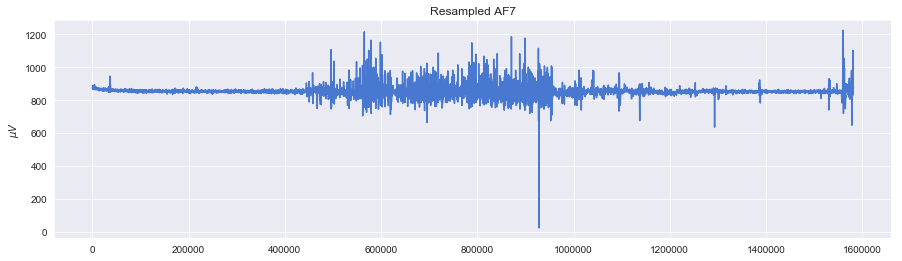

In [7]:
AF7 = signal.resample(data_5_21.clean_RAW_AF7, 256 * len(data_5_21.clean_RAW_AF7))
AF8 = signal.resample(data_5_21.clean_RAW_AF8, 256 * len(data_5_21.clean_RAW_AF8))
TP9 = signal.resample(data_5_21.clean_RAW_TP9, 256 * len(data_5_21.clean_RAW_TP9))
TP10 = signal.resample(data_5_21.clean_RAW_TP10, 256 * len(data_5_21.clean_RAW_TP10))

plt.figure(figsize= (15, 4))
plt.plot(AF7)
plt.title('Resampled AF7')
plt.ylabel(r'$ \mu V $')
plt.show()

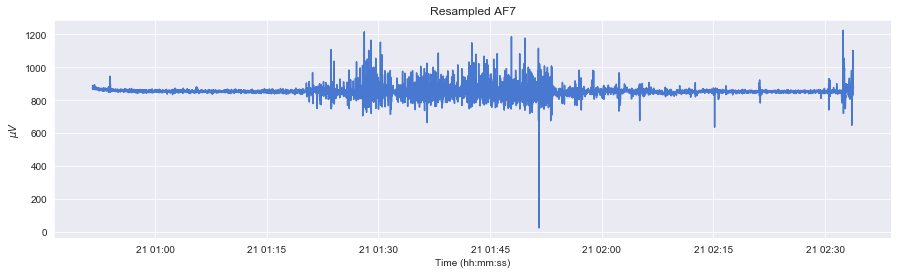

In [8]:
def interpolateNaNs(channelData):
    nans =  np.isnan(channelData)
    x = lambda z: z.to_numpy().nonzero()[0]
    
    interpolated = channelData.copy()
    interpolated[nans] = np.interp(x(nans), x(~nans), channelData[~nans])
    return interpolated



data_5_21['clean_RAW_AF7'] = interpolateNaNs(data_5_21.RAW_AF7)
AF7 = signal.resample(data_5_21.clean_RAW_AF7, 256 * len(data_5_21.clean_RAW_AF7))
resampled_time = pd.to_datetime(np.linspace(data_5_21.index[0].value, 
                                data_5_21.index[-1].value, 
                                256 * len(data_5_21.index.values)))
plt.figure(figsize= (15, 4))
plt.plot(resampled_time, AF7)
plt.title('Resampled AF7')
plt.ylabel(r'$ \mu V $')
plt.xlabel('Time (hh:mm:ss)')
plt.show()

# Analysis

Transform to Time-Frequency Decomposition via STFT. DC current at 0 to 1 Hz excluded. There is a notch filter for 60 Hz intervals. Seems to be a cycle, but still not visible to eye.

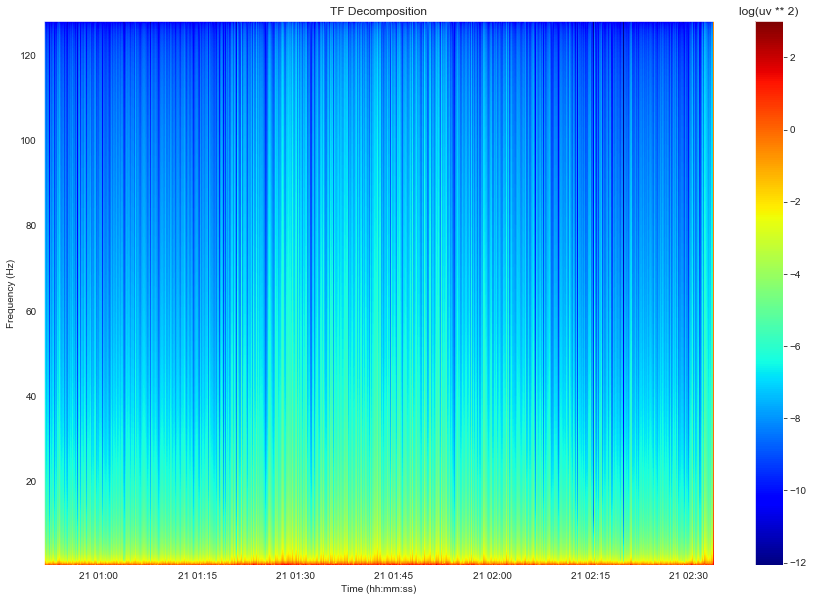

In [9]:
def stft(data, time, fs = 256, window = 'hann'):
    f, t, Zxx = signal.stft(data, fs = fs, window = window, nperseg = fs * 5)
    plt.figure(figsize = (15, 10))
    time = pd.to_datetime(np.linspace(time[0].value, time[-1].value, 
                   t.shape[0]))
    plt.pcolormesh(time, f, np.log10(np.abs(Zxx)), cmap = plt.cm.jet)
    plt.ylim([0.5, fs / 2])
    cbar = plt.colorbar()
    cbar.ax.set_title('log(uv ** 2)')
    plt.title('TF Decomposition')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (hh:mm:ss)')
    
    plt.show()
    return f, time, Zxx

f, t, Zxx = stft(AF7, data_5_21.index)

Sleep can be categorized by the type of brain waves, the presence of certain frequencies in the signal. Slow wave sleep (SWS) is often categorized by an increased presence of delta power (1-4Hz), so that was investigated. 

-- as seen in the data (battery restriction only allowed up to certain amount of time unfortunately), there is a cyclic pattern of sleep depth that forms. We can visualize a trend from light sleep to SWS (deep sleep, characterized by increased delta power), back to light sleep, and back to deep sleep until the Muse EEG battery fails. This can be seen in the pwer log-transformed

In [10]:
def deltaPowerTimeSeries(f, t, Zxx):
    delta_frequency = np.zeros([t.shape[0]])
    for index, freq in enumerate(f):
        if (freq >= 1 and freq <= 4.0): # Hz 
            delta_frequency += np.abs(Zxx[index, :])
    power_at_Delta = ((delta_frequency))[1:-2] # filter edge artifacts
    time = t[1:-2] 
    return time, power_at_Delta

time, power_at_Delta = deltaPowerTimeSeries(f,t,Zxx)

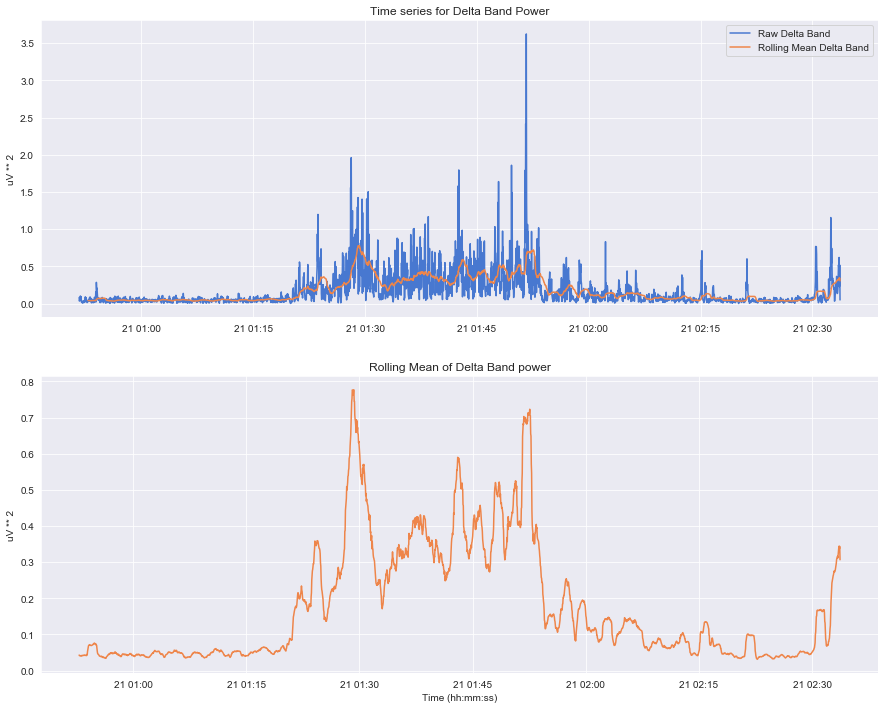

In [11]:
plt.figure(figsize = (15, 12))
plt.subplot(2, 1, 1)
plt.plot(time, power_at_Delta)
plt.plot(time, pd.Series(power_at_Delta).rolling(30).mean())
plt.legend(['Raw Delta Band', 'Rolling Mean Delta Band'])
plt.title('Time series for Delta Band Power')
plt.ylabel('uV ** 2')

plt.subplot(2, 1, 2)
plt.plot(time, pd.Series(power_at_Delta).rolling(30).mean(), 'C1')
plt.title('Rolling Mean of Delta Band power')
plt.xlabel('Time (hh:mm:ss)')
plt.ylabel('uV ** 2')
plt.show()

Log-transformed Power

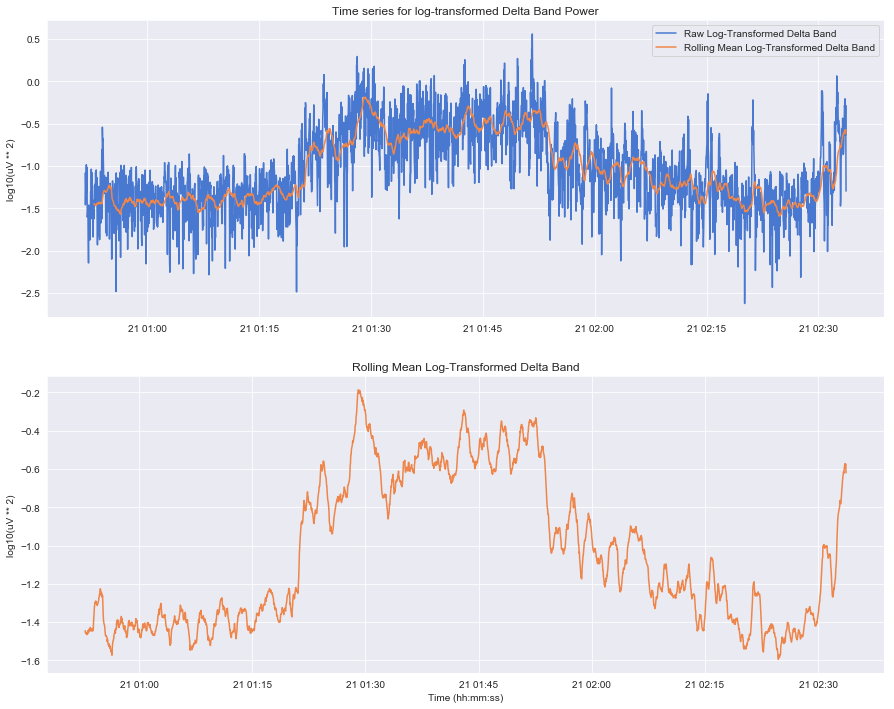

In [12]:
plt.figure(figsize = (15, 12))
plt.subplot(2, 1, 1)
plt.plot(time, np.log10(power_at_Delta))
plt.plot(time, pd.Series(np.log10(power_at_Delta)).rolling(30).mean())
plt.legend(['Raw Log-Transformed Delta Band', 'Rolling Mean Log-Transformed Delta Band'])
plt.title('Time series for log-transformed Delta Band Power')
plt.ylabel('log10(uV ** 2)')

plt.subplot(2, 1, 2)
plt.plot(time, pd.Series(np.log10(power_at_Delta)).rolling(30).mean(), 'C1')
plt.title('Rolling Mean Log-Transformed Delta Band')
plt.ylabel('log10(uV ** 2)')
plt.xlabel('Time (hh:mm:ss)')
plt.show()

# Pipeline for analysis of rest of channels and new data